##### Copyright 2020 The TensorFlow Authors.

In [121]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

Based on https://www.tensorflow.org/quantum/tutorials/mnist

We build a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [122]:
#!pip3 install -q tensorflow==2.3.1
!python3.8 -m pip install -q tensorflow==2.4.1
!python3.8 -m pip install tensorboard_plugin_profile==2.3.0
%load_ext tensorboard

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfq-nightly 0.5.0.dev20210516 requires grpcio==1.30.0, but you have grpcio 1.32.0 which is incompatible.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Install TensorFlow Quantum:

In [123]:
#!pip3 install -q tensorflow-quantum
!python3.8 -m pip install tfq-nightly

  Using cached grpcio-1.30.0-cp38-cp38-macosx_10_9_x86_64.whl (2.8 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.30.0 which is incompatible.


Now import TensorFlow and the module dependencies:

In [124]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import datetime
# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# set the random seed
tf.random.set_seed(137)
np.random.seed(137)

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [125]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [126]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [127]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


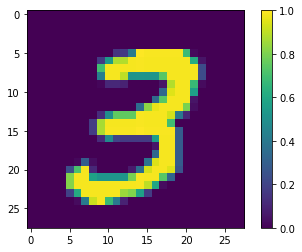

In [128]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [129]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize: 

True


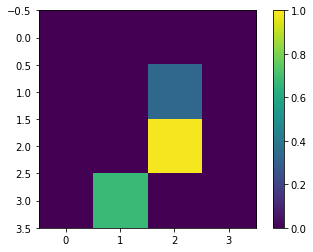

In [130]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [131]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [132]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [133]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [134]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [135]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

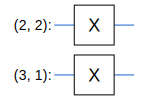

In [136]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [137]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [138]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

Helper functions for Tensorboard.


- The integer values of samples, so that you can create histograms of the distribution.
- The linear XEB fidelity estimate of a set of samples, to give some indication of how "truly quantum random" the samples are.


In [139]:
@tf.function
def bits_to_ints(bits):
    """Convert tensor of bitstrings to tensor of ints."""
    sigs = tf.constant([1 << i for i in range(N_QUBITS)], dtype=tf.int32)
    rounded_bits = tf.clip_by_value(tf.math.round(
        tf.cast(bits, dtype=tf.dtypes.float32)), clip_value_min=0, clip_value_max=1)
    return tf.einsum('jk,k->j', tf.cast(rounded_bits, dtype=tf.dtypes.int32), sigs)

@tf.function
def xeb_fid(bits):
    """Compute linear XEB fidelity of bitstrings."""
    final_probs = tf.squeeze(
        tf.abs(tfq.layers.State()(REFERENCE_CIRCUIT).to_tensor()) ** 2)
    nums = bits_to_ints(bits)
    return (2 ** N_QUBITS) * tf.reduce_mean(tf.gather(final_probs, nums)) - 1.0


### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [140]:
print(tfq.util.get_supported_gates().keys())
print(tfq.util.get_supported_channels().keys())

class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout, dropout_aux_qubits=[]):
        self.data_qubits = data_qubits
        self.readout = readout
        self.curr_layer_id = 0
        self.dropout_aux_qubits = dropout_aux_qubits
    
    def add_layer(self, circuit, gate, prefix):
        dropout_id = np.random.randint(0, len(self.data_qubits) + 1)
        for i in range(len(self.data_qubits)):
            print(self.data_qubits)
            qubit = self.data_qubits[i]
            symbol = sympy.Symbol(prefix + '_' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
        if self.curr_layer_id >= len(self.dropout_aux_qubits):
            # It is expected that len(self.dropout_aux_qubits) == num_layers-1. This is because
            # Dropout essentially changes the input of the next layer, so we only have enough aux qubits for n-1 layers.
            # Also, this if helps us avoid the qubit-switching logic if we don't actually have dropout.
            return
        # switch qubit with the right zero-qubit
        if dropout_id < len(self.data_qubits):
            tmp = self.data_qubits[dropout_id]
            self.data_qubits[dropout_id] = self.dropout_aux_qubits[self.curr_layer_id]
            self.dropout_aux_qubits[self.curr_layer_id] = tmp
        self.curr_layer_id += 1

dict_keys([cirq.X, cirq.XX, cirq.Y, cirq.YY, cirq.Z, cirq.ZZ, cirq.H, cirq.CZ, cirq.CNOT, cirq.SWAP, cirq.ISWAP, cirq.PhasedXPowGate(phase_exponent=0.123), cirq.PhasedISwapPowGate(phase_exponent=0.123), cirq.FSimGate(theta=0.123, phi=0.456), cirq.I])
dict_keys([cirq.depolarize(p=0.01), cirq.asymmetric_depolarize(error_probabilities={'I': 0.94, 'X': 0.01, 'Y': 0.02, 'Z': 0.03}), cirq.generalized_amplitude_damp(p=0.01,gamma=0.02), cirq.amplitude_damp(gamma=0.01), cirq.ResetChannel(), cirq.phase_damp(gamma=0.01), cirq.phase_flip(p=0.01), cirq.bit_flip(p=0.01)])


Build an example circuit layer to see how it looks:

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [141]:
def create_quantum_model(apply_dropout=False):
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    if apply_dropout:
        aux1 = cirq.GridQubit(0, -1)
        aux2 = cirq.GridQubit(1, -1)
        aux_qubits = [aux1, aux2]
    else:
        aux_qubits = []
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout,
        dropout_aux_qubits=aux_qubits)

    # Then add layers (TODO: experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    builder.add_layer(circuit, cirq.XX, "xx2")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(3, 0)]
[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(3, 0)]
[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(3, 0)]
[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(3, 0)]
[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(-2, -2)]
[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(-2, -2)]
[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(-2, -2)]
[cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(-2, -2)]
[cirq.GridQubit(-3, -3), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(-2, -2)]
[cirq.GridQubit(-3, -3), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(-2, -2)]
[cirq.GridQubit(-3, -3), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0), cirq.GridQubit(-2, -2)]
[

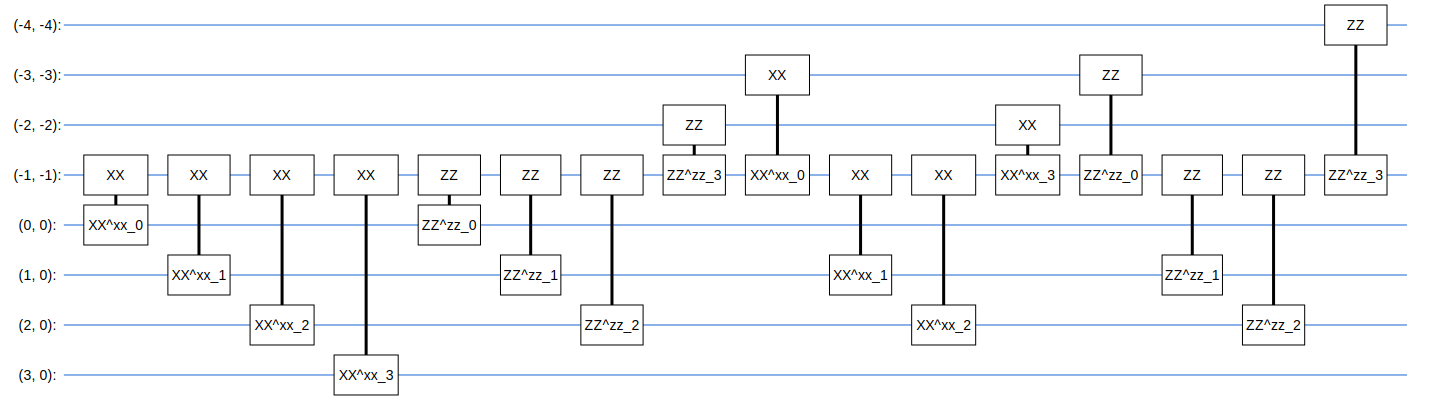

In [142]:
aux1 = cirq.GridQubit(-2, -2)
aux2 = cirq.GridQubit(-3, -3)
aux3 = cirq.GridQubit(-4, -4)
aux_qubits = [aux1, aux2, aux3]
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1),
                                   dropout_aux_qubits=aux_qubits)

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
demo_builder.add_layer(circuit, gate = cirq.ZZ, prefix='zz')
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
demo_builder.add_layer(circuit, gate = cirq.ZZ, prefix='zz')
SVGCircuit(circuit)

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.Gr

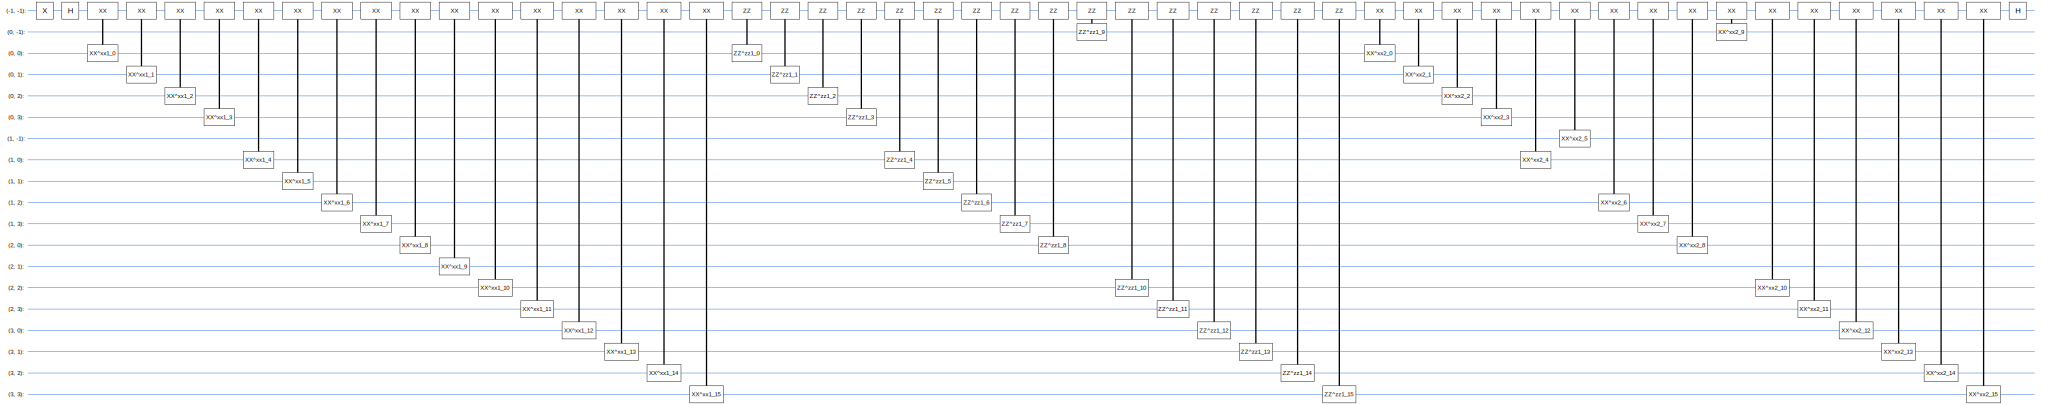

In [143]:
model_circuit, model_readout = create_quantum_model(apply_dropout=True)
SVGCircuit(model_circuit)

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [144]:
# Build the Keras model.
qlayer = tfq.layers.PQC(model_circuit, model_readout)
print(len(qlayer.get_weights()[0]))

model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    qlayer,
])

48


Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [145]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [146]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [147]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [148]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_7 (PQC)                  (None, 1)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
None


## 3. TensorBoard

In [150]:
logdir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [151]:
EPOCHS = 3
BATCH_SIZE = 32
NUM_EXAMPLES = 500

In [152]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [153]:
def train_model(apply_dropout=False):
    for i in range(EPOCHS):
        # HACK - build new quantum circuit for each epoch and copy over the weights from the old one
        model_circuit, model_readout = create_quantum_model(apply_dropout)
        
        if i == 0:
            qlayer = tfq.layers.PQC(model_circuit, model_readout)
        else:
            qlayer_new = tfq.layers.PQC(model_circuit, model_readout,
                                             initializer=tf.keras.initializers.Zeros)
            qlayer_new.set_weights(qlayer.get_weights())
            qlayer = qlayer_new

        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(), dtype=tf.string),
            qlayer,
        ])
        model.compile(
            loss=tf.keras.losses.Hinge(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[hinge_accuracy])

        # Now fit the model for this epoch
        model.fit(
              x_train_tfcirc_sub, y_train_hinge_sub,
              batch_size=32,
              epochs=1,
              verbose=1,
              validation_data=(x_test_tfcirc, y_test_hinge),
              callbacks=[tensorboard_callback])
    return model

In [154]:
model = train_model(apply_dropout=False)

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.Gr

16/16 [==============================] - 34s 2s/step - loss: 0.9985 - hinge_accuracy: 0.5883 - val_loss: 0.9983 - val_hinge_accuracy: 0.5544
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2)

16/16 [==============================] - 41s 3s/step - loss: 0.9973 - hinge_accuracy: 0.5833 - val_loss: 0.9975 - val_hinge_accuracy: 0.5519
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2)

16/16 [==============================] - 30s 2s/step - loss: 0.9957 - hinge_accuracy: 0.5833 - val_loss: 0.9964 - val_hinge_accuracy: 0.5529


In [155]:
print("Non-dropout training set perf:")
model.evaluate(x_train_tfcirc_sub, y_train_hinge_sub)
print("Non-dropout test set perf:")
qnn_results = model.evaluate(x_test_tfcirc, y_test)

Non-dropout training set perf:
16/16 [==============================] - 3s 177ms/step - loss: 0.9959 - hinge_accuracy: 0.5473
Non-dropout test set perf:
62/62 [==============================] - 12s 186ms/step - loss: 0.9964 - hinge_accuracy: 0.5529


In [156]:
dropout_model = train_model(apply_dropout=True)

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.Gr

16/16 [==============================] - 58s 4s/step - loss: 1.0054 - hinge_accuracy: 0.4648 - val_loss: 1.0041 - val_hinge_accuracy: 0.5292
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2)

16/16 [==============================] - 54s 3s/step - loss: 0.9989 - hinge_accuracy: 0.5446 - val_loss: 1.0101 - val_hinge_accuracy: 0.4113
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(1, 3), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2), cirq.GridQubit(2, 3), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1), cirq.GridQubit(3, 2), cirq.GridQubit(3, 3)]
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2)

16/16 [==============================] - 143s 9s/step - loss: 1.0014 - hinge_accuracy: 0.4906 - val_loss: 1.0056 - val_hinge_accuracy: 0.4561


In [157]:
print("Dropout training set perf:")
dropout_model.evaluate(x_train_tfcirc_sub, y_train_hinge_sub)
print("Dropout test set perf:")
qnn_results = dropout_model.evaluate(x_test_tfcirc, y_test)

Dropout training set perf:
16/16 [==============================] - 16s 967ms/step - loss: 0.9943 - hinge_accuracy: 0.5246
Dropout test set perf:
62/62 [==============================] - 54s 860ms/step - loss: 1.0056 - hinge_accuracy: 0.4561


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 4. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [158]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)             

In [159]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 1s 13ms/step - loss: 0.0057 - accuracy: 0.9990


The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [160]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
81/81 - 1s - loss: 0.6579 - accuracy: 0.5250 - val_loss: 0.6457 - val_accuracy: 0.4878
Epoch 2/20
81/81 - 0s - loss: 0.6325 - accuracy: 0.5525 - val_loss: 0.6172 - val_accuracy: 0.5701
Epoch 3/20
81/81 - 0s - loss: 0.5962 - accuracy: 0.6614 - val_loss: 0.5704 - val_accuracy: 0.7642
Epoch 4/20
81/81 - 0s - loss: 0.5455 - accuracy: 0.8182 - val_loss: 0.5161 - val_accuracy: 0.8237
Epoch 5/20
81/81 - 0s - loss: 0.4965 - accuracy: 0.8508 - val_loss: 0.4702 - val_accuracy: 0.8318
Epoch 6/20
81/81 - 0s - loss: 0.4564 - accuracy: 0.8564 - val_loss: 0.4347 - val_accuracy: 0.8308
Epoch 7/20
81/81 - 0s - loss: 0.4255 - accuracy: 0.8578 - val_loss: 0.4075 - val_accuracy: 0.8308
Epoch 8/20
81/81 - 0s - loss: 0.4008 - accuracy: 0.8582 - val_loss: 0.3854 - val_accuracy: 0.8323
Epoch 9/20
81/81 - 0s - loss: 0.3807 - accuracy: 0.8667 - val_loss: 0.3675 - val_accuracy: 0.8709
Epoch 10/20
81/81 - 0s - loss: 0.3637 - accuracy: 0.8803 - val_loss: 0.3522 - val_accuracy: 0.8709
Epoch 11/20
81/81 -

## 5. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

/Users/rickyyoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

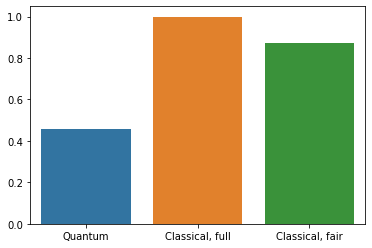

In [162]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])